#Royal Cybers: End-to-End Machine Learning Pipeline for Personalized recommendations in Databricks 

## Load Dataset

In [0]:
# Load Dataset from S3 Bucket
cosmetic_store_data_path = "s3://e-commerce-pipeline-dataset/Cosmetic Store Website Data.csv"
reviews_data_path = "s3://e-commerce-pipeline-dataset/nyka_top_brands_cosmetics_product_reviews.csv"
product_mapping_path = "s3://e-commerce-pipeline-dataset/unique_product_id_pairings.csv"

cosmetic_df = spark.read.csv(cosmetic_store_data_path, header=True, inferSchema=True)
reviews_df = spark.read.csv(reviews_data_path, header=True, inferSchema=True)
mapping_df = spark.read.csv(product_mapping_path, header=True, inferSchema=True)

In [0]:
cosmetic_df.show(5)

+-------------------+----------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2020-01-01 00:00:00|      view|   5809910|1602943681873052386|         NULL| grattol| 5.24|595414620|4adb70bb-edbd-498...|
|2020-01-01 00:00:09|      view|   5812943|1487580012121948301|         NULL|kinetics| 3.97|595414640|c8c5205d-be43-4f1...|
|2020-01-01 00:00:19|      view|   5798924|1783999068867920626|         NULL|  zinger| 3.97|595412617|46a5010f-bd69-4fb...|
|2020-01-01 00:00:24|      view|   5793052|1487580005754995573|         NULL|    NULL| 4.92|420652863|546f6af3-a517-475...|
|2020-01-01 00:00:25|      view|   5899926|2115334439910245200|         NULL|    NULL| 3.92|484071203|cff70ddf-529e-4b0...|
+-------

In [0]:
reviews_df.show(5)

+----------+----------+---------+--------------------+--------------------+--------------+-------------------+-------------+----------+--------+--------------+--------------------+----+-----+--------------+--------------------+------------+--------------------+
|product_id|brand_name|review_id|        review_title|         review_text|        author|        review_date|review_rating|is_a_buyer|pro_user|  review_label|       product_title| mrp|price|product_rating|product_rating_count|product_tags|         product_url|
+----------+----------+---------+--------------------+--------------------+--------------+-------------------+-------------+----------+--------+--------------+--------------------+----+-----+--------------+--------------------+------------+--------------------+
|    781070|      Olay| 16752142|Worth buying 50g one|Works as it claim...| Ashton Dsouza|2021-01-23 15:17:18|          5.0|      True|   False|Verified Buyer|Olay Ultra Lightw...|1999| 1599|           4.1|        

In [0]:
mapping_df.show(5)

+-----------------+------------------+
|product_id_events|product_id_reviews|
+-----------------+------------------+
|            11719|            209281|
|            15161|           2645330|
|            16686|           3445855|
|            27658|           4749403|
|            34768|            995305|
+-----------------+------------------+
only showing top 5 rows



%md
## Initial Data Cleaning

In [0]:
# Drop Duplicates
cosmetic_df = cosmetic_df.dropDuplicates()
reviews_df = reviews_df.dropDuplicates()
mapping_df = mapping_df.dropDuplicates()

In [0]:
# Standardizing column names
cosmetic_df = cosmetic_df.withColumnRenamed("product_id", "cosmeticProductId") \
                         .withColumnRenamed("price", "cosmetic_price") 

reviews_df = reviews_df.withColumnRenamed("product_id", "reviewProductId") \
                       .withColumnRenamed("price", "review_price")

mapping_df = mapping_df.withColumnRenamed("product_id_events", "cosmeticProductId") \
                       .withColumnRenamed("product_id_reviews", "reviewProductId")

In [0]:
# Drop unnecessary columns and fill missing values
cosmetic_df = cosmetic_df.filter(cosmetic_df['cosmetic_price'] > 0)

mapping_df = mapping_df.na.drop()

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

In [0]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.replace('\n', ' ')  # Remove new lines
        text = text.replace('\t', ' ')  # Remove tabs
        text = text.replace('\r', ' ')  # Remove returns
        text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphanumeric characters except spaces
        words = text.split()  # Tokenize the text
        words = [word for word in words if word not in stop_words]  # Remove stopwords
        text = ' '.join(words)  # Combine words back into text
        return text.strip()
    return text  # Return original value if not a string (e.g., NaN)

# Register the clean_text function as a UDF
clean_text_udf = udf(clean_text, StringType())

# Drop unnecessary columns and handle missing values
reviews_df = reviews_df.drop("product_tags")
reviews_df = reviews_df.fillna({
    'review_text': 'No review', 
    'brand_name': 'Unknown', 
    'review_label': 'No Label',
    'product_title': 'Unknown Title'
})

# Apply the UDF to clean the review_title and review_text columns
reviews_df = reviews_df.withColumn("review_title_clean", clean_text_udf(reviews_df["review_title"]))
reviews_df = reviews_df.withColumn("review_text_clean", clean_text_udf(reviews_df["review_text"]))

# Show the results
reviews_df.select("review_title", "review_title_clean", "review_text", "review_text_clean").show(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+------------------+------------------+--------------------+--------------------+
|      review_title|review_title_clean|         review_text|   review_text_clean|
+------------------+------------------+--------------------+--------------------+
|Invisible & Smooth|  invisible smooth|Wore these when I...|wore massive brea...|
|              Nice|              nice|Works as it claim...|works claims smal...|
|             Great|             great|It Won't let your...|wont let pimple g...|
|          Easy fix|          easy fix|This is one easy ...|one easy fix redu...|
|        Give a try|          give try|This is my first ...|first purchase tr...|
+------------------+------------------+--------------------+--------------------+
only showing top 5 rows



In [0]:
# Filtering our multi classificaiton 
valid_events = ["view", "cart", "remove_from_cart", "purchase"]
cosmetic_df = cosmetic_df.filter(cosmetic_df.event_type.isin(valid_events))

cosmetic_df.groupBy("event_type").count().show()

+----------------+-------+
|      event_type|  count|
+----------------+-------+
|        purchase| 263570|
|            view|2032076|
|            cart|1126995|
|remove_from_cart| 609461|
+----------------+-------+



In [0]:
cosmetic_df.show(5)

+-------------------+----------+-----------------+-------------------+-------------+--------+--------------+---------+--------------------+
|         event_time|event_type|cosmeticProductId|        category_id|category_code|   brand|cosmetic_price|  user_id|        user_session|
+-------------------+----------+-----------------+-------------------+-------------+--------+--------------+---------+--------------------+
|2020-01-01 00:00:19|      view|          5798924|1783999068867920626|         NULL|  zinger|          3.97|595412617|46a5010f-bd69-4fb...|
|2020-01-01 00:00:25|      view|          5899926|2115334439910245200|         NULL|    NULL|          3.92|484071203|cff70ddf-529e-4b0...|
|2020-01-01 00:00:24|      view|          5793052|1487580005754995573|         NULL|    NULL|          4.92|420652863|546f6af3-a517-475...|
|2020-01-01 00:00:09|      view|          5812943|1487580012121948301|         NULL|kinetics|          3.97|595414640|c8c5205d-be43-4f1...|
|2020-01-01 00:00:00

In [0]:
reviews_df.show(5)

+---------------+--------------+---------+------------------+--------------------+-----------------+-------------------+-------------+----------+--------+--------------+--------------------+---+------------+--------------+--------------------+--------------------+------------------+--------------------+
|reviewProductId|    brand_name|review_id|      review_title|         review_text|           author|        review_date|review_rating|is_a_buyer|pro_user|  review_label|       product_title|mrp|review_price|product_rating|product_rating_count|         product_url|review_title_clean|   review_text_clean|
+---------------+--------------+---------+------------------+--------------------+-----------------+-------------------+-------------+----------+--------+--------------+--------------------+---+------------+--------------+--------------------+--------------------+------------------+--------------------+
|         785729|Nykaa Naturals| 27389259|Invisible & Smooth|Wore these when I...|   

In [0]:
mapping_df.show(5)

+-----------------+---------------+
|cosmeticProductId|reviewProductId|
+-----------------+---------------+
|            34768|         995305|
|            15161|        2645330|
|            16686|        3445855|
|            19162|        3494214|
|            11719|         209281|
+-----------------+---------------+
only showing top 5 rows



## Manage Delta Tables

In [0]:
# # Example: Deleting the directory in DBFS
# dbutils.fs.rm("dbfs:/mnt/delta/combined_cleaned_data", True)  # True for recursive delete

# dbutils.fs.rm("dbfs:/mnt/delta/cosmetic_store_data", True)  # True for recursive delete
# dbutils.fs.rm("dbfs:/mnt/delta/product_reviews", True)  # True for recursive delete
# dbutils.fs.rm("dbfs:/mnt/delta/product_mapping", True)  # True for recursive delete

In [0]:
cosmetic_delta_path = "/mnt/delta/cosmetic_store_data"
reviews_delta_path = "/mnt/delta/product_reviews"
mapping_delta_path = "/mnt/delta/product_mapping"

In [0]:
# Convert each cleaned DataFrame to Delta format
cosmetic_df.write.format("delta").mode("overwrite").save(cosmetic_delta_path)
reviews_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(reviews_delta_path)
mapping_df.write.format("delta").mode("overwrite").save(mapping_delta_path)


In [0]:
# Load Delta tables directly from paths
cosmetic_df = spark.read.format("delta").load(cosmetic_delta_path)
reviews_df = spark.read.format("delta").load(reviews_delta_path)
mapping_df = spark.read.format("delta").load(mapping_delta_path)


## Feature Engineering

### Unstructed Data

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
import nltk
from pyspark.sql.functions import col

In [0]:

reviews_df = reviews_df.withColumn("review_title_clean", col("review_title_clean").cast(StringType()))
reviews_df = reviews_df.withColumn("review_text_clean", col("review_text_clean").cast(StringType()))

reviews_df = reviews_df.fillna({'review_title_clean': 'No title', 'review_text_clean': 'No review'})

In [0]:
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [0]:
nlp = spacy.load("en_core_web_sm")

# Define the stemming and lemmatization functions
def process_text_spacy(text):
    try:
        if isinstance(text, str) and text:
            doc = nlp(text)
            lemmatized = " ".join([token.lemma_ for token in doc])  # Lemmatization using SpaCy
            stemmed = " ".join([token.text[:3] for token in doc])   # Simulated "stemming" by truncating words (example)
            return stemmed, lemmatized
        else:
            return "", ""  # Handle invalid input gracefully
    except Exception as e:
        print(f"Error processing text: {text} | Error: {e}")
        return "", ""

# Register UDFs for stemming and lemmatization
stem_udf = udf(lambda text: process_text_spacy(text)[0], StringType())
lemmatize_udf = udf(lambda text: process_text_spacy(text)[1], StringType())

# Fill missing values for relevant columns
reviews_df = reviews_df.fillna({
    "review_title_clean": "No title",
    "review_text_clean": "No review"
})

# Apply UDFs to DataFrame columns
reviews_df = reviews_df.withColumn("stemmed_title", stem_udf(reviews_df["review_title_clean"]))
reviews_df = reviews_df.withColumn("lemmatized_title", lemmatize_udf(reviews_df["review_title_clean"]))
reviews_df = reviews_df.withColumn("stemmed_text", stem_udf(reviews_df["review_text_clean"]))
reviews_df = reviews_df.withColumn("lemmatized_text", lemmatize_udf(reviews_df["review_text_clean"]))

# Show results for titles
reviews_df.select("review_title_clean", "stemmed_title", "lemmatized_title").show(5)

# Show results for text
reviews_df.select("review_text_clean", "stemmed_text", "lemmatized_text").show(5)

+------------------+-------------+----------------+
|review_title_clean|stemmed_title|lemmatized_title|
+------------------+-------------+----------------+
|        best cream|      bes cre|      good cream|
|          good one|      goo one|        good one|
|       rd purchase|       rd pur|     rd purchase|
|        nykaa skin|      nyk ski|      nykaa skin|
|     great product|      gre pro|   great product|
+------------------+-------------+----------------+
only showing top 5 rows

+--------------------+--------------------+--------------------+
|   review_text_clean|        stemmed_text|     lemmatized_text|
+--------------------+--------------------+--------------------+
|literally best cr...| lit bes cre ant agi|literally good cr...|
|                    |                    |                    |
|rd purchase good ...|rd pur goo tim bu...|rd purchase good ...|
|result awesome re...|res awe res see o...|result awesome re...|
|seems small perfe...|     see sma per tra|seem smal

### Structured Data

#### Outcome Variable (Y): Customer Engagement Level

In [0]:
from pyspark.sql.functions import datediff, current_date
from pyspark.sql.functions import min, max
from pyspark.sql.functions import countDistinct
from pyspark.ml.feature import StringIndexer

In [0]:
#Encode event_type to map engagement levels
cosmetic_df = cosmetic_df.drop("event_type_index")

indexer = StringIndexer(inputCol="event_type", outputCol="event_type_index")
cosmetic_df = indexer.fit(cosmetic_df).transform(cosmetic_df)

cosmetic_df.select("event_type", "event_type_index").distinct().show()

+----------------+----------------+
|      event_type|event_type_index|
+----------------+----------------+
|        purchase|             3.0|
|            cart|             1.0|
|            view|             0.0|
|remove_from_cart|             2.0|
+----------------+----------------+



In [0]:
# Distribution of classes
cosmetic_df.groupBy("event_type_index").count().show()

+----------------+-------+
|event_type_index|  count|
+----------------+-------+
|             0.0|2032076|
|             1.0|1126995|
|             3.0| 263570|
|             2.0| 609461|
+----------------+-------+



#### Predictor Variables (X): Structured Features

In [0]:
from pyspark.sql.functions import datediff, current_date
from pyspark.sql.functions import min, max
from pyspark.sql.functions import countDistinct

In [0]:
#Recency: Days since the last interaction

cosmetic_df = cosmetic_df.withColumn("recency", datediff(current_date(), col("event_time")))

In [0]:
# Frequency: Total interactions per user session

frequency_df = cosmetic_df.groupBy("user_session").count().withColumnRenamed("count", "frequency")
cosmetic_df = cosmetic_df.join(frequency_df, on="user_session", how="left")

In [0]:
# Product Popularity: Number of purchases per product

product_popularity = cosmetic_df.filter(col("event_type") == "purchase").groupBy("cosmeticProductId").count().withColumnRenamed("count", "popularity")
cosmetic_df = cosmetic_df.join(product_popularity, on="cosmeticProductId", how="left")

In [0]:
#Session Diversity: Number of unique product categories viewed in a session

session_diversity = cosmetic_df.groupBy("user_session").agg(countDistinct("category_code").alias("session_diversity"))
cosmetic_df = cosmetic_df.join(session_diversity, on="user_session", how="left")

## Data Transformation

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import mean, stddev, col
from pyspark.sql.types import DoubleType, IntegerType

### Transform Cosmetic Data (Structured Interaction Data)

In [0]:
# Scale `cosmetic_price` column
assembler = VectorAssembler(inputCols=["cosmetic_price"], outputCol="price_vec")
cosmetic_df = assembler.transform(cosmetic_df)

scaler = StandardScaler(inputCol="price_vec", outputCol="price_scaled")
cosmetic_df = scaler.fit(cosmetic_df).transform(cosmetic_df)

### Transform Reviews Data with GPT Tokenizer (Unstructured Sentiment Data)

In [0]:
from transformers import AutoTokenizer, AutoModel

# Load a pre-trained GPT-like model
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
model = AutoModel.from_pretrained("EleutherAI/gpt-neo-1.3B")

# Encode text to embeddings
text = "This moisturizer is amazing for dry skin!"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
print(embeddings)

2024-11-24 02:03:11.979292: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 02:03:12.031116: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 02:03:12.241739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 02:03:14.464239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[[-0.16730331 -1.3368105  -0.01049148 ...  0.62573016  1.1977668
  -1.2075031 ]]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [0]:
# Cast numerical columns to appropriate types
reviews_df = reviews_df.withColumn("mrp", reviews_df["mrp"].cast(DoubleType())) \
    .withColumn("review_price", reviews_df["review_price"].cast(DoubleType())) \
    .withColumn("product_rating", reviews_df["product_rating"].cast(DoubleType())) \
    .withColumn("product_rating_count", reviews_df["product_rating_count"].cast(IntegerType()))

### Transform Mapping Data

In [0]:
# Cast columns to IntegerType in `mapping_df`
mapping_df = mapping_df.withColumn("cosmeticProductId", mapping_df["cosmeticProductId"].cast(IntegerType()))
mapping_df = mapping_df.withColumn("reviewProductId", mapping_df["reviewProductId"].cast(IntegerType()))

# Calculate mean and standard deviation for filtering outliers
stats = mapping_df.select(
    mean("reviewProductId").alias("mean_reviews"),
    stddev("reviewProductId").alias("stddev_reviews")
).collect()[0]

mean_reviews = stats["mean_reviews"]
stddev_reviews = stats["stddev_reviews"]

# Filter out outliers beyond 3 standard deviations
mapping_df = mapping_df.filter(
    (col("reviewProductId") > mean_reviews - 3 * stddev_reviews) &
    (col("reviewProductId") < mean_reviews + 3 * stddev_reviews)
)

# Scale `cosmeticProductId` and `reviewProductId` in `mapping_df`
assembler = VectorAssembler(inputCols=["cosmeticProductId", "reviewProductId"], outputCol="mapping_features_vec")
mapping_df = assembler.transform(mapping_df)

scaler = StandardScaler(inputCol="mapping_features_vec", outputCol="mapping_scaled_features")
mapping_df = scaler.fit(mapping_df).transform(mapping_df)

## Combine the Transformed Data

In [0]:
# Join `cosmetic_df` and `mapping_df` on `cosmeticProductId`
cosmetic_mapped_df = cosmetic_df.join(mapping_df, cosmetic_df["cosmeticProductId"] == mapping_df["cosmeticProductId"], "inner")

# Join the result with `reviews_df` on `reviewProductId`
combined_df = cosmetic_mapped_df.join(reviews_df, cosmetic_mapped_df["reviewProductId"] == reviews_df["reviewProductId"], "inner")

# Drop the duplicate one
combined_df = combined_df.drop("cosmeticProductId", "reviewProductId", "event_type", "brand_name", "stemmed_title", "lemmatized_title", 
"stemmed_text", "lemmatized_text", "review_text_clean",  "review_title_clean")

In [0]:
# Save combined_df to Delta table
combined_data_path = "/mnt/delta/combined_cleaned_data"
combined_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(combined_data_path)

In [0]:
combined_df.printSchema()

root
 |-- user_session: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- cosmetic_price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- event_type_index: double (nullable = false)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = true)
 |-- popularity: long (nullable = true)
 |-- session_diversity: long (nullable = true)
 |-- price_vec: vector (nullable = true)
 |-- price_scaled: vector (nullable = true)
 |-- mapping_features_vec: vector (nullable = true)
 |-- mapping_scaled_features: vector (nullable = true)
 |-- review_id: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- is_a_buyer: string (nullable =

In [0]:
combined_df.show(5)

+--------------------+-------------------+-------------------+-------------+------+--------------+---------+----------------+-------+---------+----------+-----------------+---------+-------------------+--------------------+-----------------------+---------+--------------------+--------------------+--------------------+-------------------+-------------+----------+--------+--------------+--------------------+-----+------------+--------------+--------------------+--------------------+
|        user_session|         event_time|        category_id|category_code| brand|cosmetic_price|  user_id|event_type_index|recency|frequency|popularity|session_diversity|price_vec|       price_scaled|mapping_features_vec|mapping_scaled_features|review_id|        review_title|         review_text|              author|        review_date|review_rating|is_a_buyer|pro_user|  review_label|       product_title|  mrp|review_price|product_rating|product_rating_count|         product_url|
+--------------------+----

## Exploratory Data Analysis

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


In [0]:
# Summary statistics for numeric columns
combined_df.describe().show()

+-------+--------------------+--------------------+--------------------+-------+-----------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+--------------------+--------------------+
|summary|        user_session|         category_id|       category_code|  brand|   cosmetic_price|            user_id|  event_type_index|           recency|        frequency|        popularity|  session_diversity|           review_id|        review_title|         review_text|              author|         review_date|       review_rating|          is_a_buyer|          pro_user|        review_label|      product_title|              mrp|      review_price|    product_rating|produ

In [0]:
# Calculate specific statistics
combined_df.select("cosmetic_price", "review_price", "product_rating", "product_rating_count").describe().show()


+-------+-----------------+------------------+-----------------+--------------------+
|summary|   cosmetic_price|      review_price|   product_rating|product_rating_count|
+-------+-----------------+------------------+-----------------+--------------------+
|  count|          3889948|           3888207|          3889090|             3889437|
|   mean|6.803305887368991|442.46164671788307|4.424189591911089|   7192.410815755597|
| stddev|9.864445453158451| 249.8975158777531|14.43695063627094|   12825.31601903842|
|    min|             0.32|               5.0|              1.5|                   1|
|    max|           184.13|            2947.0|           1103.0|               98477|
+-------+-----------------+------------------+-----------------+--------------------+



In [0]:
# Average product rating by brand
combined_df.groupBy("brand").agg({"product_rating": "avg"}).withColumnRenamed("avg(product_rating)", "average_rating").show()

+---------+------------------+
|    brand|    average_rating|
+---------+------------------+
|depilflax| 4.799597264684023|
|   ardell| 4.351248172565016|
|     NULL| 4.497763329848901|
|   masura|  4.26233221041742|
|    konad| 4.318323677948051|
|  bluesky|  4.16570341300966|
|   runail|4.1651109199730705|
|   entity| 4.449711237941344|
| ingarden|  4.07247776886427|
|   gehwol|               4.0|
|     enas|3.9420638805715624|
|      opi|               4.0|
|      cnd| 4.010292253304722|
|   sophin|11.066700796359376|
+---------+------------------+



### Distribution of Price

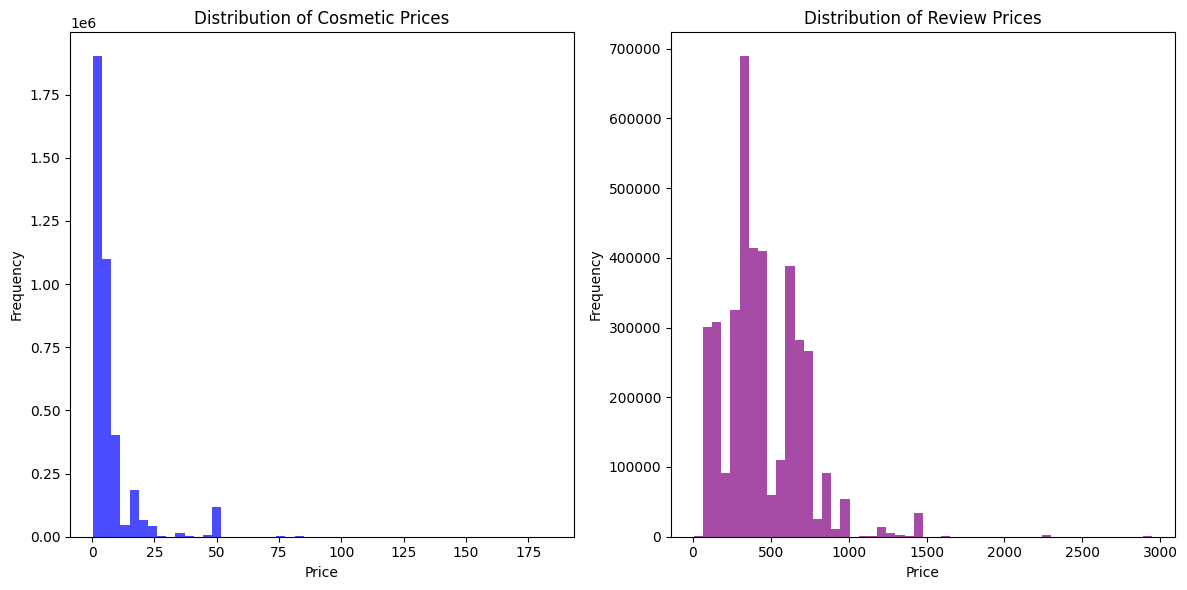

In [0]:
# Distribution of cosmetic_price and review_price to understand pricing across products

cosmetic_price_data = combined_df.select("cosmetic_price").rdd.flatMap(lambda x: x).collect()
review_price_data = combined_df.select("review_price").rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

plt.figure(figsize=(12, 6))

# Histogram for cosmetic_price
plt.subplot(1, 2, 1)
plt.hist(cosmetic_price_data, bins=50, color="blue", alpha=0.7)
plt.title("Distribution of Cosmetic Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Histogram for review_price
plt.subplot(1, 2, 2)
plt.hist(review_price_data, bins=50, color="purple", alpha=0.7)
plt.title("Distribution of Review Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Product Rating Distribution

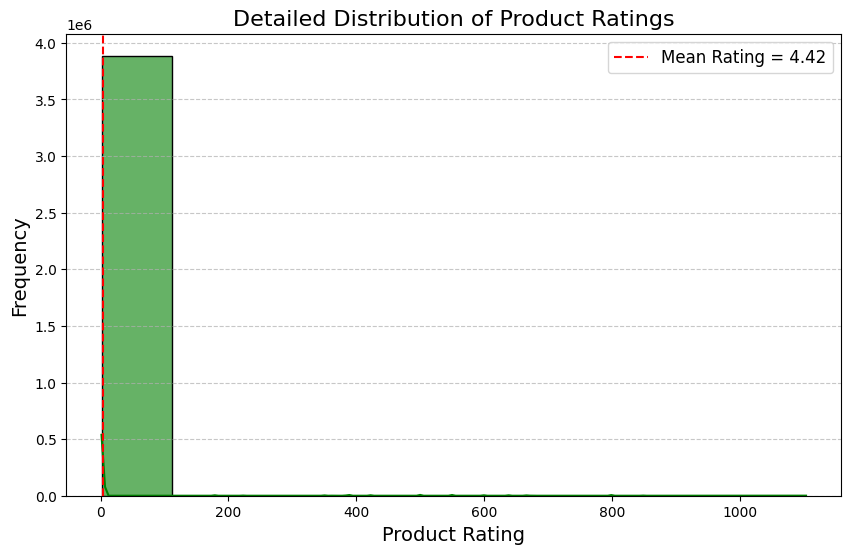

In [0]:
# Collect rating data and filter out None values
rating_data = combined_df.select("product_rating").rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

plt.figure(figsize=(10, 6))
sns.histplot(rating_data, bins=10, kde=True, color="green", alpha=0.6)

# Mean rating calculation
mean_rating = np.mean(rating_data)
plt.axvline(mean_rating, color="red", linestyle="--", label=f"Mean Rating = {mean_rating:.2f}")

plt.title("Detailed Distribution of Product Ratings", fontsize=16)
plt.xlabel("Product Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Customer Engagement Patterns Over Time

+----------+------+
|event_date| count|
+----------+------+
|2020-01-01| 75966|
|2020-01-02| 99253|
|2020-01-03|103953|
|2020-01-04|100535|
|2020-01-05| 97520|
|2020-01-06| 99593|
|2020-01-07|104468|
|2020-01-08|111154|
|2020-01-09|123578|
|2020-01-10| 83693|
|2020-01-11|130860|
|2020-01-12|139827|
|2020-01-13|152676|
|2020-01-14|124106|
|2020-01-15|139207|
|2020-01-16|170937|
|2020-01-17|131742|
|2020-01-18|102404|
|2020-01-19|141684|
|2020-01-20|168794|
+----------+------+
only showing top 20 rows



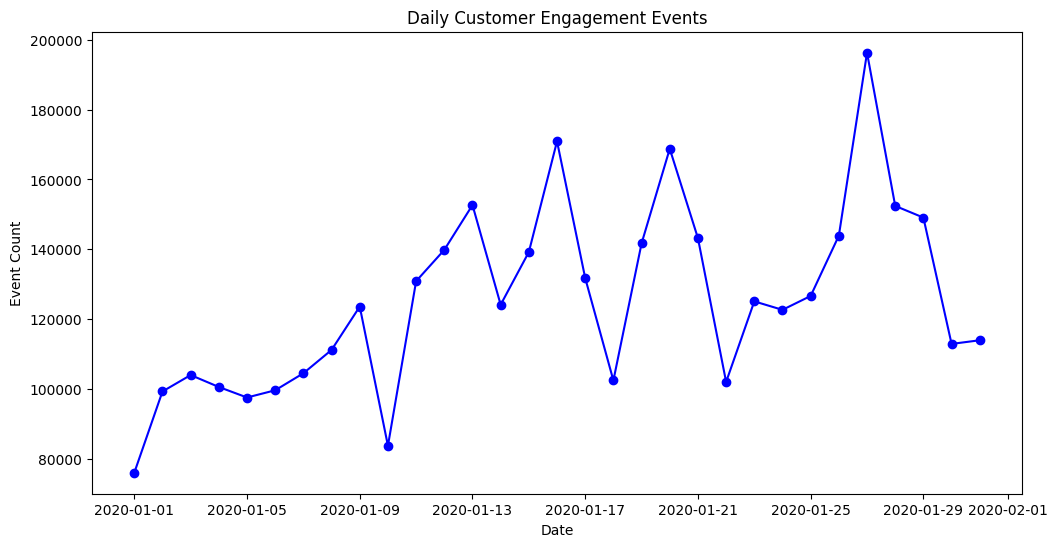

In [0]:
combined_df = combined_df.withColumn("event_date", col("event_time").cast("date"))

# Count engagement events per day
daily_engagement = combined_df.groupBy("event_date").count().orderBy("event_date")
daily_engagement.show()

date_data = daily_engagement.select("event_date").rdd.flatMap(lambda x: x).collect()
engagement_data = daily_engagement.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.plot(date_data, engagement_data, color="blue", marker="o")
plt.title("Daily Customer Engagement Events")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.show()


### Distribution of Customer Engagement Levels (Event Types)

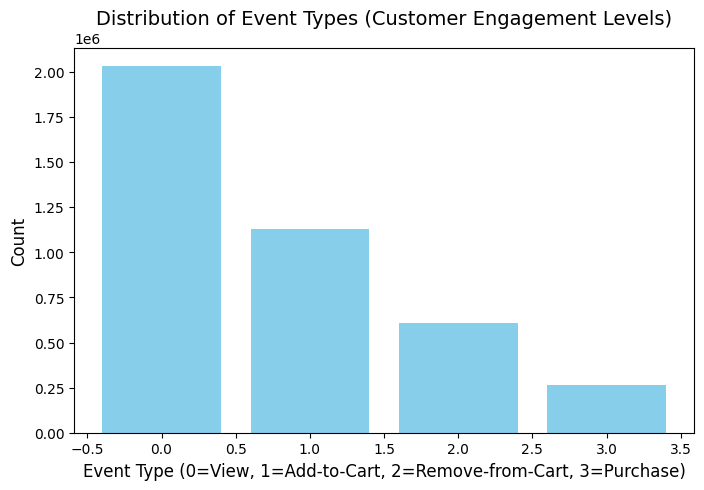

In [0]:
# Count occurrences of each class
event_counts = cosmetic_df.groupBy("event_type_index").count().toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(event_counts["event_type_index"], event_counts["count"], color="skyblue")
plt.title("Distribution of Event Types (Customer Engagement Levels)", fontsize=14)
plt.xlabel("Event Type (0=View, 1=Add-to-Cart, 2=Remove-from-Cart, 3=Purchase)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

### Sentimental Analysis

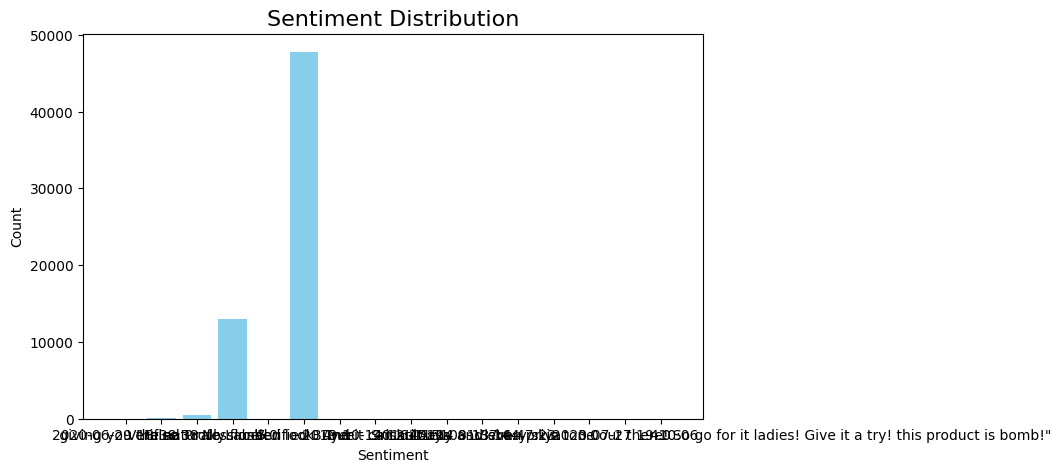

In [0]:
sentiment_counts = reviews_df.groupBy("review_label").count().toPandas()

plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts["review_label"], sentiment_counts["count"], color="skyblue")
plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


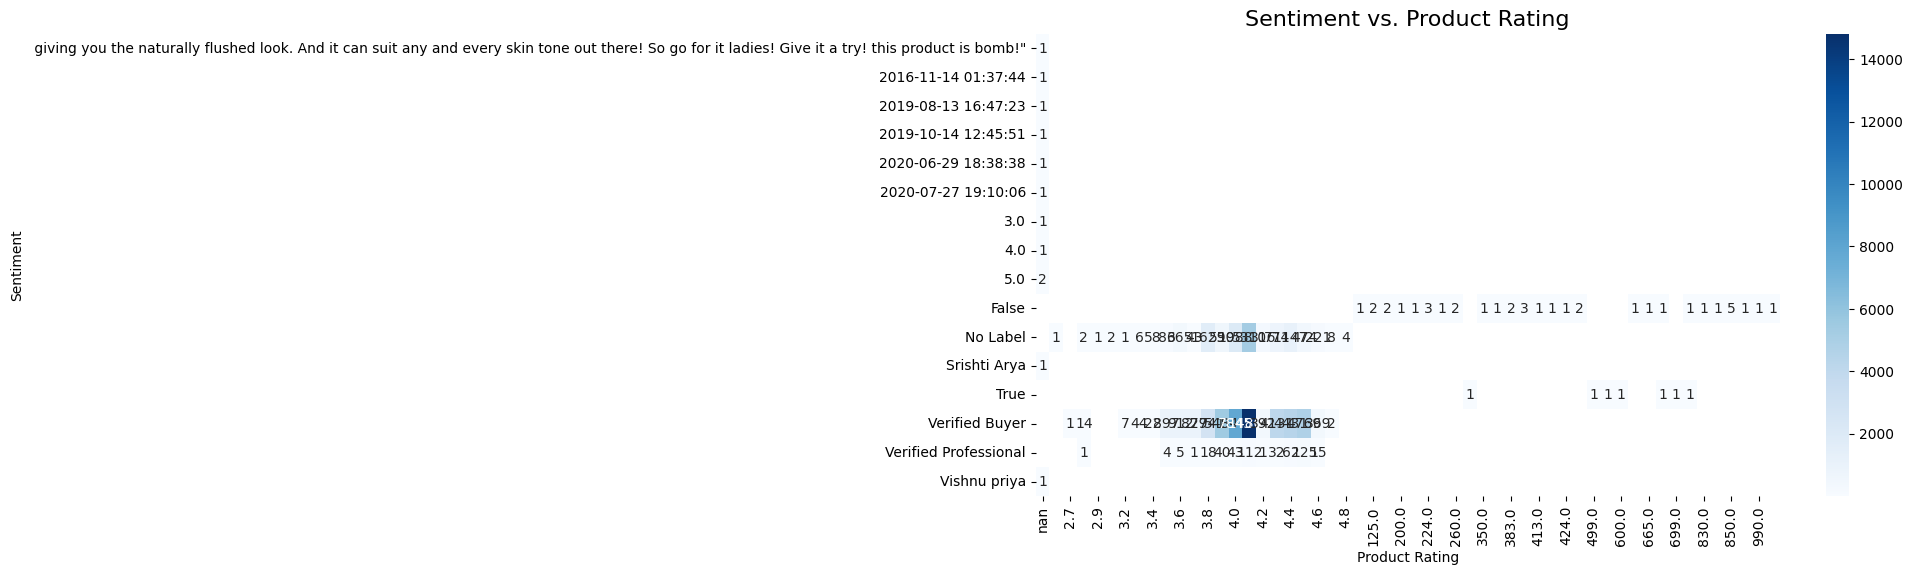

In [0]:
# Sentiment by Product Rating
sentiment_rating = reviews_df.groupBy("review_label", "product_rating").count().toPandas()
pivot_data = sentiment_rating.pivot(index="review_label", columns="product_rating", values="count")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="Blues", cbar=True)
plt.title("Sentiment vs. Product Rating", fontsize=16)
plt.xlabel("Product Rating")
plt.ylabel("Sentiment")
plt.show()

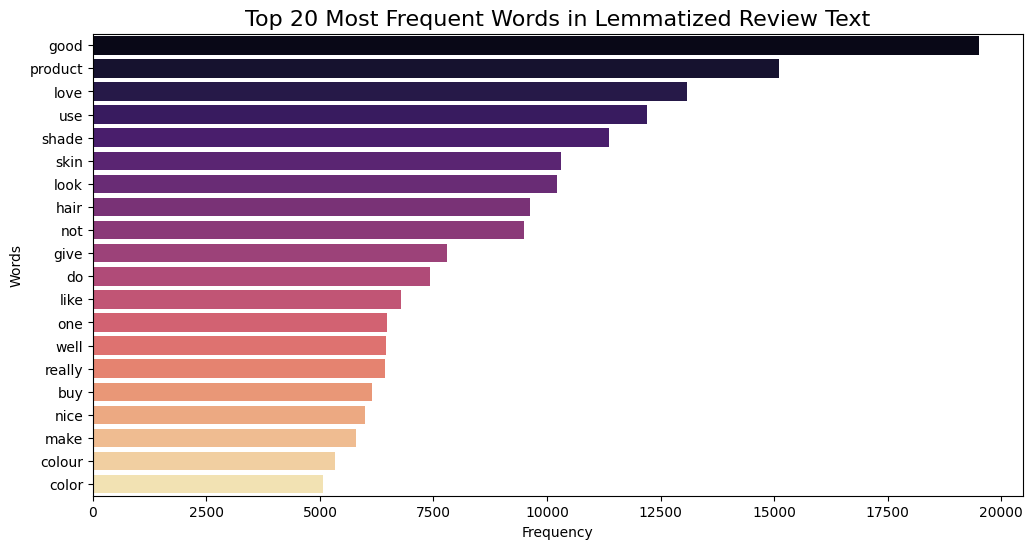

In [0]:
from collections import Counter

# Collect lemmatized text into a single string
lemmatized_texts = reviews_df.select("lemmatized_text").rdd.flatMap(lambda x: x).collect()
all_words = " ".join([text for text in lemmatized_texts if text]).split()

# Calculate word frequencies
word_freq = Counter(all_words).most_common(20)

# Separate words and counts for plotting
words, counts = zip(*word_freq)

# Plot most common words
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="magma")
plt.title("Top 20 Most Frequent Words in Lemmatized Review Text", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()



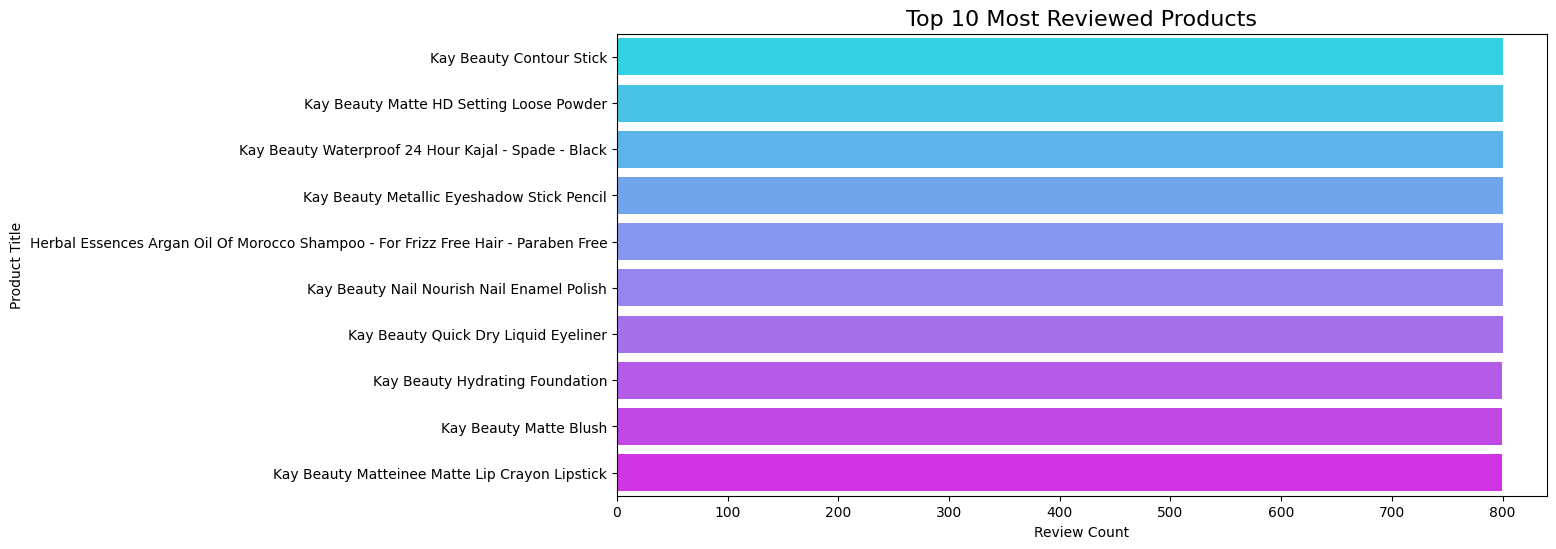

In [0]:
top_products = reviews_df.groupBy("product_title").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="product_title", data=top_products, palette="cool")
plt.title("Top 10 Most Reviewed Products", fontsize=16)
plt.xlabel("Review Count")
plt.ylabel("Product Title")
plt.show()

#### Time Series Analysis of Ratings

+------------------+------------------+
|review_date_parsed|        avg_rating|
+------------------+------------------+
|              NULL| 527.1788617886178|
|        2013-05-20|               4.0|
|        2013-10-07|3.8000000000000003|
|        2014-04-16|4.1000000000000005|
|        2014-04-29|               4.0|
|        2014-05-23|               4.1|
|        2014-05-28|               4.1|
|        2014-05-31|               4.0|
|        2014-06-03|4.1000000000000005|
|        2014-06-04|3.9897727272727277|
|        2014-06-06|3.8000000000000003|
|        2014-06-11|               4.1|
|        2014-06-21|               4.1|
|        2014-06-24|               4.1|
|        2014-06-30|               4.1|
|        2014-07-01| 4.100000000000001|
|        2014-07-08|3.8000000000000003|
|        2014-07-09|               4.1|
|        2014-07-14|               4.1|
|        2014-07-17|               4.1|
+------------------+------------------+
only showing top 20 rows



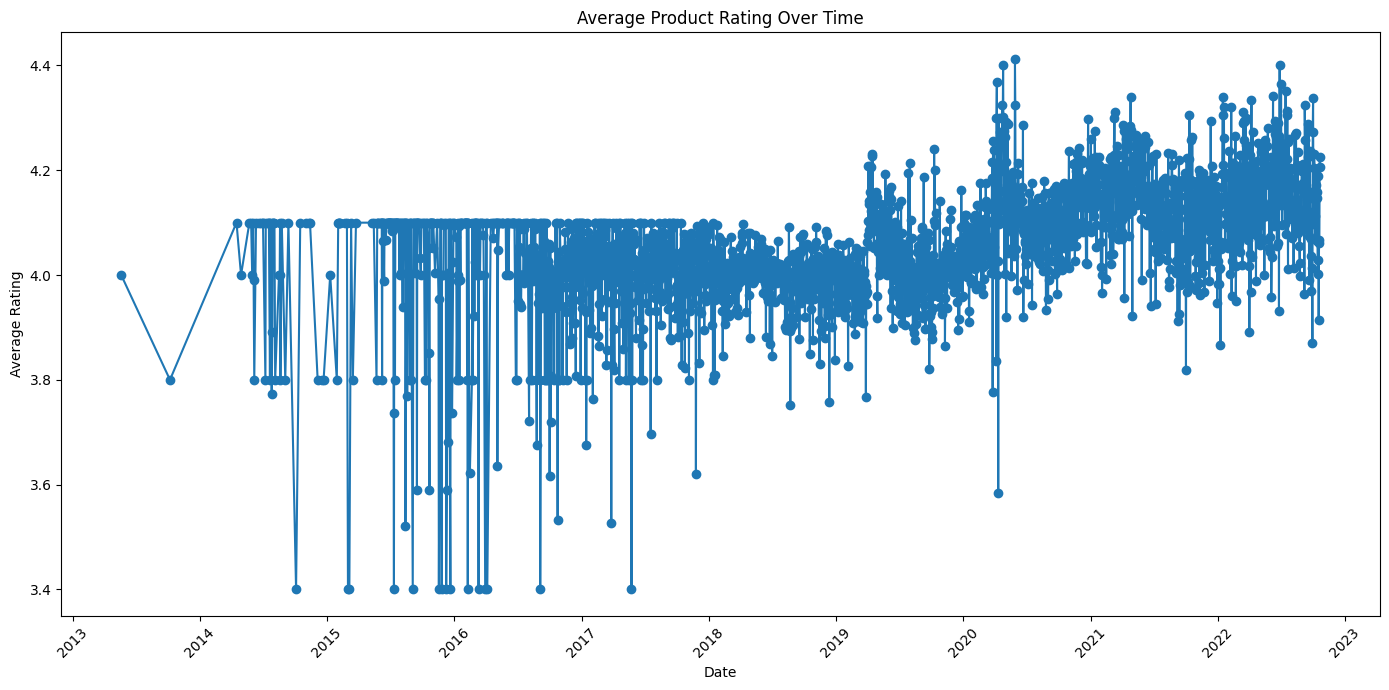

In [0]:
from pyspark.sql import functions as F

# Extract date from review_date
combined_df = combined_df.withColumn(
    "review_date_parsed",
    F.to_timestamp("review_date", "yyyy-MM-dd HH:mm:ss").cast("date")
)

# Proceed with grouping and aggregation
daily_ratings = combined_df.groupBy("review_date_parsed").agg(
    F.avg("product_rating").alias("avg_rating")
).orderBy("review_date_parsed")

daily_ratings.show()

# Plot time series
date_data = [row['review_date_parsed'] for row in daily_ratings.collect()]
rating_data = [row['avg_rating'] for row in daily_ratings.collect()]

plt.figure(figsize=(14, 7))
plt.plot(date_data, rating_data, marker='o', linestyle='-')
plt.title('Average Product Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### User Behavior Analysis

+---------+-----+
|  user_id|count|
+---------+-----+
|379181470|20229|
|602284233|13827|
|526596989|13260|
|598055880|11887|
|508506759|10167|
|549941895| 9836|
|595792732| 9393|
|269803542| 9360|
|596854010| 9143|
| 53613286| 9045|
+---------+-----+
only showing top 10 rows



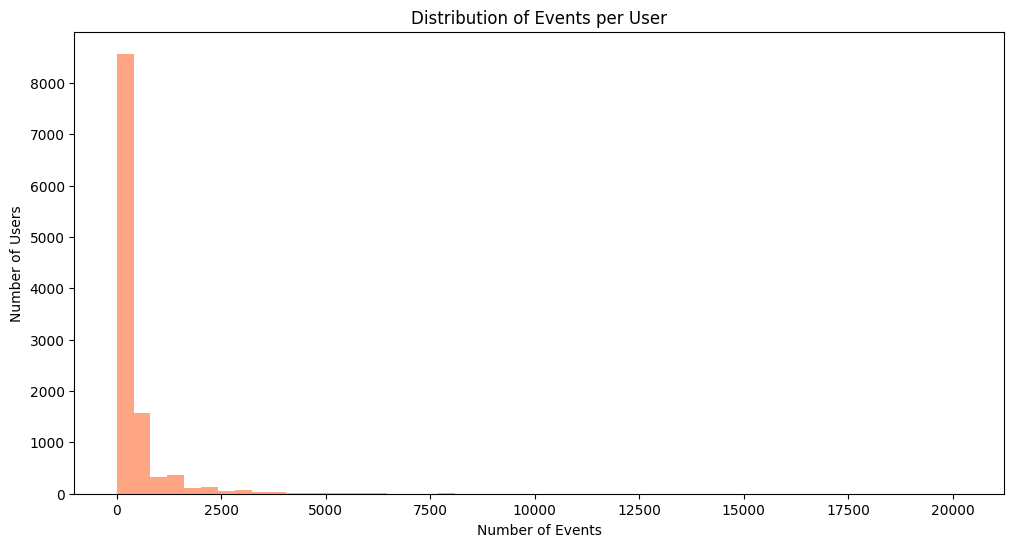

In [0]:
# Number of events per user
user_events = combined_df.groupBy("user_id").count().orderBy(F.desc("count"))
user_events.show(10)

# Plot distribution of events per user
event_counts = user_events.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(event_counts, bins=50, color="coral", alpha=0.7)
plt.title('Distribution of Events per User')
plt.xlabel('Number of Events')
plt.ylabel('Number of Users')
plt.show()

#### Distribution of Product Ratings by Brand

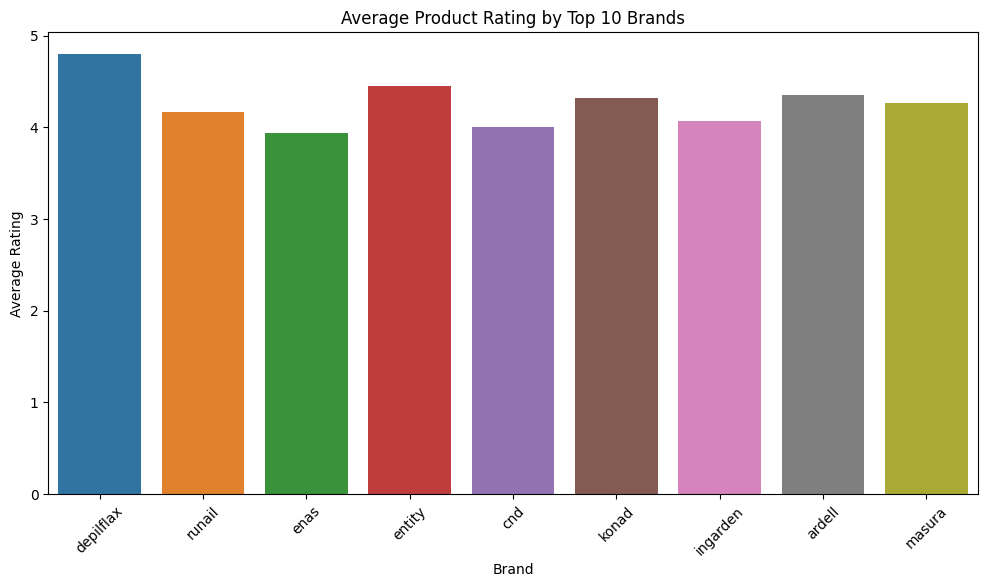

In [0]:
# Average rating per brand
brand_ratings = combined_df.groupBy("brand").agg(
    F.avg("product_rating").alias("avg_rating"),
    F.count("product_rating").alias("rating_count")
)

top_brands_ratings = brand_ratings.orderBy(F.desc("rating_count")).limit(10)
top_brands_pd = top_brands_ratings.toPandas()

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='avg_rating', data=top_brands_pd)
plt.xticks(rotation=45)
plt.title('Average Product Rating by Top 10 Brands')
plt.xlabel('Brand')
plt.ylabel('Average Rating')
plt.show()

#### Convert Review Ratings to Numeric and Analyze

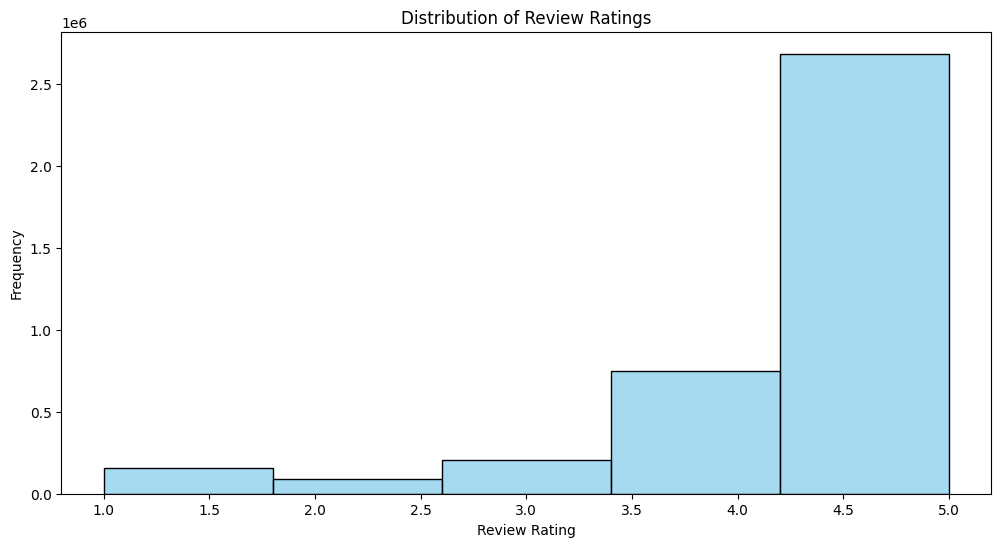

In [0]:
# Convert review_rating to numeric
combined_df = combined_df.withColumn("review_rating_num", F.col("review_rating").cast("double"))

# Drop rows where conversion failed
combined_df = combined_df.na.drop(subset=["review_rating_num"])

# Histogram of review ratings
review_rating_data = combined_df.select("review_rating_num").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
sns.histplot(review_rating_data, bins=5, kde=False, color="skyblue")
plt.title('Distribution of Review Ratings')
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.show()

#### Session-Level Analysis

+--------------------+-----+
|        user_session|count|
+--------------------+-----+
|dc659625-aa39-470...|11191|
|b2528609-d6e9-4ec...| 9385|
|0542c088-0256-469...| 9030|
|b678bd37-d894-4ac...| 8536|
|4e13419f-074d-4ae...| 7777|
|db069885-d8c6-40b...| 7695|
|7ad04b55-bf1f-4f4...| 7617|
|0c002789-f20f-4ac...| 7448|
|2534bba9-1488-41e...| 7370|
|d0836902-0046-4df...| 6740|
+--------------------+-----+
only showing top 10 rows



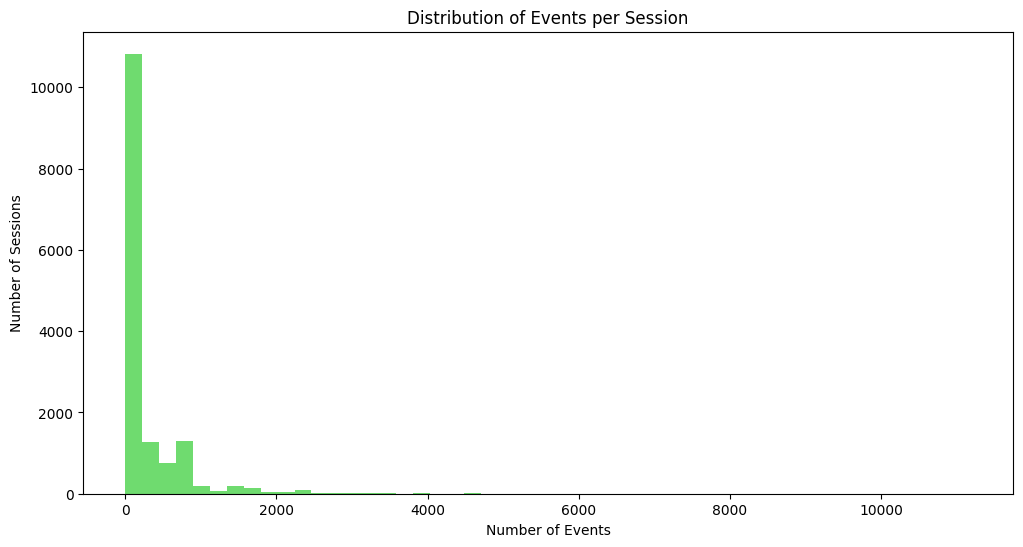

In [0]:
# Number of events per session
session_events = combined_df.groupBy("user_session").count().orderBy(F.desc("count"))
session_events.show(10)

# Distribution plot
session_counts = session_events.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(session_counts, bins=50, color="limegreen", alpha=0.7)
plt.title('Distribution of Events per Session')
plt.xlabel('Number of Events')
plt.ylabel('Number of Sessions')
plt.show()